Из-за сильнейшего ливня в лаборатории квантовой механики произошёл потоп, вследствие чего она была закрыта на срочный ремонт.  
Однако учёные привыкли доводить все свои дела до конца, и ждать пока закончится ремонт были не намерены. Перед ними стояла задача определить критические температуры для сверхпроводников, созданных на основе различных химических элементов. Однако никаких привычных лабораторных приспособлений для этого не имелось, существовала только информация о характеристиках каждого из сверхпроводников и химические формулы сверхпроводников, которую им подсказали ученые-химики из соседней лаборатории. В поисках решения они решили изучить новейшие технологии в области анализа данных и обнаружили, что им может помочь машинное обучение. 

Помогите учёным-физикам, не имеющим опыта в решении задач машинного обучения, определить критические температуры всех сверхпроводников используя их характеристики и химический состав. 

Для обучения моделей необходимо воспользоваться информацией о сверхпроводниках, для которых ученые успели получить критическую температуру (train.csv). 

Возможно сделать предсказание более эффективным вам поможет химическая формула для каждого из сверхпроводников (formula_train.csv). 
Целевым полем является поле critical_temperature.  
Ваша задача для недостающих соединений (test.csv) предсказать поле critical_temperature и в качестве ответа загрузить файл answer.csv, где будет одна колонка с предсказанием (без заголовка колонки).

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def metrics_eval(y_true, y_pred, res=True):
    """
    Evaluate MAE, MSE, SMAPE, RMSE, MAPE metrics
    :param y_true: np.array of true values
    :param y_pred: np.array of predicted values
    :param res: bool, printing results
    :return: list of metrics
    """
    # Mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean squared error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred) / 2))) * 100

    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    r2 = r2_score(y_true, y_pred)

    if res:
        print('Mean Absolute Error:', round(mae, 3))
        print('Mean Squared Error:', round(mse, 3))
        print('Root Mean Squared Error:', round(rmse, 3))
        print('Mean absolute percentage error:', round(MAPE, 3))
        print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
        print('r2_score:', round(r2, 3))

    return mae, mse, rmse, MAPE, SMAPE, r2

In [10]:
# Get data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
formula_train_df = pd.read_csv("data/formula_train.csv")
formula_test_df = pd.read_csv("data/formula_test.csv")

# Process columns names
train_df.columns = train_df.columns.str.replace('\s+', '_', regex=True)
test_df.columns = test_df.columns.str.replace('\s+', '_', regex=True)
formula_train_df.columns = formula_train_df.columns.str.replace('\s+', '_', regex=True)
formula_test_df.columns = formula_test_df.columns.str.replace('\s+', '_', regex=True)

In [11]:
train_df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,critical_temperature
0,4,95.950150,87.221940,89.534122,81.423258,1.317590,1.301059,96.1190,20.285800,36.105357,...,4.10,4.053600,3.944244,1.339718,1.245504,3,1.400000,1.299038,1.135782,21.50
1,5,83.244760,59.224400,59.506081,36.126175,1.311510,1.372050,192.9810,25.192187,67.233835,...,2.40,2.402249,2.259897,1.519383,1.365077,3,0.933333,1.200000,1.019804,62.00
2,2,23.035850,26.647510,21.192566,25.010514,0.614232,0.435817,18.0583,18.243490,9.029150,...,5.10,4.242641,4.873514,0.636514,0.465999,3,3.300000,1.500000,1.374773,0.29
3,4,81.756699,79.833804,76.282833,75.275775,1.312596,1.149324,81.4820,28.789976,32.890369,...,3.62,3.309751,3.413039,1.333736,1.019322,3,1.920000,1.118034,1.198165,19.50
4,2,67.485250,69.699016,57.442709,59.574464,0.548263,0.521345,70.8405,39.638078,35.420250,...,6.00,6.000000,6.000000,0.693147,0.691193,0,0.375000,0.000000,0.000000,5.36


In [12]:
formula_train_df.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Eu1Fe1.5Ru0.5As2
1,0.0,0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,Bi2Sr2Ca1Cu2O8
2,0.0,0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,N0.3S0.7
3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba1Fe1.9Co0.1As2
4,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Rh17S15


In [13]:
target_col = "critical_temperature"

In [14]:
train = pd.concat([train_df, formula_train_df], axis=1).drop("material",axis=1)
X = train.drop(target_col, axis=1)
Y = train[target_col]

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  train_size=0.94,
                                                  random_state=42)

In [16]:
my_scaler = MinMaxScaler()
X_train = pd.DataFrame(my_scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(my_scaler.transform(X_val), columns=X_val.columns)

## Linear regression

In [17]:
import statsmodels.api as sm

In [18]:
# Define function for residual analysis

def resid_normality_analisis(residuals, alpha=0.05):
    print("QQ-Plot of residuals")
    sm.qqplot(residuals, fit=True, line='45')
    plt.show()

    # resid distribution plot
    pd.Series(residuals).plot(kind='kde', title="Plot of residual distribution")
    plt.show()

    # Jarque-Bera Wald Test for Normality
    jbtest = sm.stats.stattools.jarque_bera(residuals)
    print('\nJarque-Bera Wald Test for Normality')
    print('Skewness of Residuals = ', jbtest[2])
    print('Kurtosis of Residuals = ', jbtest[3])
    df2 = pd.Series({'Chi-Sq( 2)': jbtest[0], 'Prob>Chi-Sq': jbtest[1]})
    print(df2)
    if jbtest[1] >= alpha:
        print("Residuals have normal distribution")
    else:
        print("Residuals have not normal distribution")

    print()
    print(pd.Series(residuals).describe())

def resid_het_analisis(X, y, alpha=0.05):
    print("Goldfeld-Quandt test:")
    GQ_test = sm.stats.diagnostic.het_goldfeldquandt(y, X,
                                                     idx=None,
                                                     split=None,
                                                     drop=None)
    df2 = pd.Series({'F(14,14)': GQ_test[0], 'Prob>F': GQ_test[1]})
    print(df2)

    if GQ_test[1] >= alpha:
        print("\nGoldfeld-Quandt test: There isn't Heteroscedasticity in residuals")
    else:
        print("\nGoldfeld-Quandt test: There is Heteroscedasticity in residuals")

def resid_autocorr_analisis(residuals):
    print("Durbin-Watson test for AR(1):")
    dw_statistic = sm.stats.durbin_watson(residuals)
    print(f"dw_statistic: {dw_statistic}")
    if (dw_statistic >= 1.5) and (dw_statistic <= 2.5):
        print("1.5 <= dw_statistic <= 2.5")
        print("There isn't autocorrelation in residuals")
    elif (dw_statistic < 1.5):
        print("dw_statistic < 1.5")
        print("There is autocorrelation in residuals")
    else:
        print("2.5 < dw_statistic")
        print("There is autocorrelation in residuals")

In [19]:
# Train full features model
regressor_OLS = sm.regression.linear_model.OLS(y_train.values, X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                              756.8
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:16:40   Log-Likelihood:                         -67596.
No. Observations:               15980   AIC:                                  1.355e+05
Df Residuals:                   15822   BIC:                                  1.367e+05
Df Model:                         158                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
feature1      -0.6518      6.906     -0.094      0.925     -14.188      12.884
feature2     187.2261     19.019      9.844      0.000     149.948     224.505
feature3    -263.2368     24.056    -10.943      0.000    -310.388    -216.085
feature4     -94.9107     18.809     -5.046      0.000    -131.779     -58.043
feature5     158.9611     23.031      6.902      0.000     113.819     204.104
feature6     -39.0126     10.901     -3.579      0.000     -60.380     -17.645
feature7       4.2574      8.316      0.512      0.609     -12.043      20.558
feature8      37.8567      4.029      9.395      0.000      29.958      45.755
feature9      22.7923      5.106      4.464      0.000      12.784      32.801
feature10    -49.7595      7.357     -6.763      0.000     -64.181     -35.339
feature11      4.5516      6.407      0.710      0.477      -8.007      17.110
feature12   -161.0236     62.385     -2.581      0.010    -283.306     -38.741
feature13    -17.3746     76.374     -0.227      0.820    -167.077     132.328
feature14    135.6173     62.004      2.187      0.029      14.082     257.153
feature15     59.5562     74.063      0.804      0.421     -85.616     204.728
feature16    -63.8437     51.930     -1.229      0.219    -165.632      37.944
feature17    119.6511     11.717     10.212      0.000      96.685     142.617
feature18     66.2736      9.970      6.647      0.000      46.731      85.817
feature19     27.1235      5.125      5.292      0.000      17.077      37.170
feature20    -55.0385     13.215     -4.165      0.000     -80.941     -29.136
feature21     -7.7007     11.493     -0.670      0.503     -30.228      14.827
feature22   -166.2182     43.465     -3.824      0.000    -251.414     -81.023
feature23    476.8596     57.392      8.309      0.000     364.364     589.355
feature24    106.0124     43.752      2.423      0.015      20.254     191.771
feature25   -412.0718     56.009     -7.357      0.000    -521.856    -302.288
feature26    -19.4048     46.653     -0.416      0.677    -110.851      72.041
feature27     39.3972     11.761      3.350      0.001      16.344      62.451
feature28     16.9906      6.637      2.560      0.010       3.980      30.001
feature29    -16.1994      4.318     -3.752      0.000     -24.663      -7.735
feature30    -24.9747     12.947     -1.929      0.054     -50.351       0.402
feature31     -9.9587      9.239     -1.078      0.281     -28.068       8.151
feature32   -124.6903     13.692     -9.107      0.000    -151.528     -97.853
feature33    113.2136     16.906      6.697      0.000      80.075     146.352
feature34     17.7907     12.764      1.394      0.163      -7.229      42.810
feature35    -10.7802     15.570     -0.692      0.489     -4

In [20]:
# Feature selection using Backward Elimination method
def backwardelimination(x, y, sl):
    numVars = x.shape[1]
    for i in range(0, numVars):
        regressor_OLS2 = sm.OLS(y, x).fit()
        maxVar = regressor_OLS2.pvalues.max()
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS2.pvalues[j].astype(float) == maxVar):
                    x = x.drop(x.columns[j], axis=1)
                    break
        else:
            break
    return x

X_modified = backwardelimination(X_train, y_train.values, 0.05)

In [21]:
# Train model with choosen features
regressor_OLS_BE = sm.OLS(y_train.values, X_modified).fit()
regressor_OLS_BE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                              1139.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:16:56   Log-Likelihood:                         -67619.
No. Observations:               15980   AIC:                                  1.354e+05
Df Residuals:                   15875   BIC:                                  1.363e+05
Df Model:                         105                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
feature2     186.5770     12.387     15.062      0.000     162.297     210.857
feature3    -273.7818     12.096    -22.634      0.000    -297.491    -250.072
feature4     -93.2715     12.678     -7.357      0.000    -118.122     -68.421
feature5     167.8824     10.257     16.368      0.000     147.778     187.987
feature6     -34.0165      9.129     -3.726      0.000     -51.910     -16.123
feature8      38.4520      3.849      9.991      0.000      30.908      45.996
feature9      24.6656      4.521      5.456      0.000      15.804      33.527
feature10    -46.1130      4.904     -9.403      0.000     -55.726     -36.500
feature12   -161.6209     42.920     -3.766      0.000    -245.749     -77.492
feature14    139.1007     42.956      3.238      0.001      54.903     223.298
feature15     37.8005      5.950      6.353      0.000      26.138      49.463
feature16    -97.9320     24.453     -4.005      0.000    -145.862     -50.002
feature17    111.0526     10.051     11.049      0.000      91.351     130.754
feature18     68.2386      8.862      7.700      0.000      50.869      85.609
feature19     26.0763      4.561      5.718      0.000      17.137      35.016
feature20    -57.8258      9.985     -5.792      0.000     -77.397     -38.255
feature21    -10.8775      5.505     -1.976      0.048     -21.667      -0.088
feature22   -123.0996     28.083     -4.383      0.000    -178.145     -68.055
feature23    432.8909     24.798     17.457      0.000     384.284     481.498
feature24     60.3809     29.477      2.048      0.041       2.602     118.160
feature25   -365.5949     25.056    -14.591      0.000    -414.708    -316.482
feature27     46.5295      7.871      5.911      0.000      31.101      61.958
feature28     18.2761      6.338      2.884      0.004       5.853      30.699
feature29    -14.9811      4.013     -3.733      0.000     -22.846      -7.116
feature30    -37.1129      7.494     -4.953      0.000     -51.801     -22.424
feature32   -110.3452      8.126    -13.579      0.000    -126.274     -94.417
feature33    108.2378      9.221     11.738      0.000      90.164     126.312
feature36    -23.3550      6.821     -3.424      0.001     -36.726      -9.984
feature38    -24.3781      5.725     -4.258      0.000     -35.601     -13.156
feature39    -17.8189      5.622     -3.170      0.002     -28.838      -6.800
feature40     27.0380      6.377      4.240      0.000      14.538      39.538
feature43     92.7462     11.731      7.906      0.000      69.753     115.740
feature44     24.7500      5.730      4.319      0.000      13.518      35.982
feature45   -118.4646     11.281    -10.501      0.000    -140.577     -96.352
feature46     16.4091      4.993      3.286      0.001       

QQ-Plot of residuals


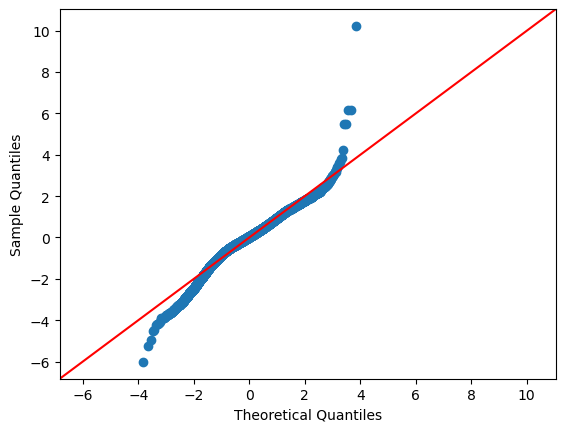

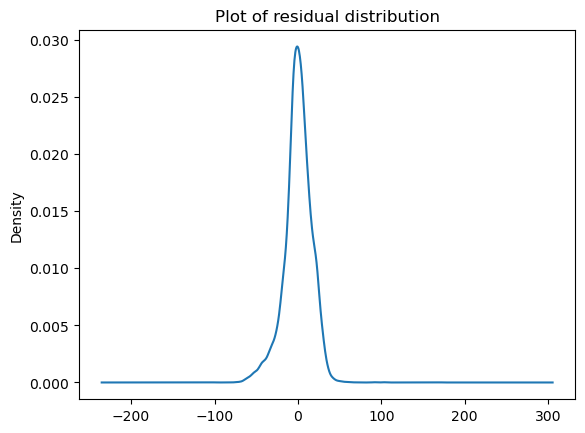


Jarque-Bera Wald Test for Normality
Skewness of Residuals =  -0.4585474348889915
Kurtosis of Residuals =  5.161716495966431
Chi-Sq( 2)     3671.459072
Prob>Chi-Sq       0.000000
dtype: float64
Residuals have not normal distribution

count    15980.000000
mean         0.003206
std         16.628200
min       -100.090317
25%         -8.247744
50%          0.591089
75%         10.328437
max        170.165555
dtype: float64

Goldfeld-Quandt test:
F(14,14)    0.933265
Prob>F      0.998877
dtype: float64

Goldfeld-Quandt test: There isn't Heteroscedasticity in residuals

Durbin-Watson test for AR(1):
dw_statistic: 1.9653281017251243
1.5 <= dw_statistic <= 2.5
There isn't autocorrelation in residuals


In [22]:
residuals = regressor_OLS.resid
resid_normality_analisis(residuals)
print()
resid_het_analisis(X_train, y_train)
print()
resid_autocorr_analisis(residuals)

# SymbolicRegressor

In [23]:
from gplearn.genetic import SymbolicRegressor
est_gp = SymbolicRegressor(population_size=5000,
                           function_set=('add', 'sub', 'mul','div','sin','cos','tan','log','sqrt'),
                           metric="mse",
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.12           785857        3          1013.67          1057.58      3.43m
   1    11.02          8272.72        3          1010.01          1090.49      4.09m
   2    15.99           215227        4          808.354          800.829      4.85m
   3    14.46      2.21653e+06        8          568.509          602.851      4.46m
   4    11.54           441837        8          568.869          599.608      3.54m
   5    17.35      3.00817e+07        8           568.49          603.021      4.98m
   6    18.59      1.19231e+07       22          542.228          534.709      5.13m
   7    16.77      1.33531e+06        8          539.247          571.694      5.74m
   8    11.07           142199       22          536.359           587.53  

SymbolicRegressor(function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'tan',
                                'log', 'sqrt'),
                  max_samples=0.9, metric='mse', p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [24]:
metrics_eval(y_val, est_gp.predict(X_val));

Mean Absolute Error: 14.065
Mean Squared Error: 372.909
Root Mean Squared Error: 19.311
Mean absolute percentage error: 196.062
Scaled Mean absolute percentage error: 64.46
r2_score: 0.689


# Neural network

In [25]:
import keras

my_callbacks = [keras.callbacks.EarlyStopping(patience=10),
                keras.callbacks.ModelCheckpoint(
                    filepath='models/best_model.h5',
                    monitor='val_loss',
                    save_weights_only=True,
                    mode='auto',
                    save_best_only=True)
]

nn_model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128,
#                        kernel_regularizer='l2',
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128,
#                        kernel_regularizer='l2',
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32,
#                        kernel_regularizer='l2',
                       activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

nn_model.compile(optimizer='adam', #rmsprop
              loss="mae",
              metrics=["mse"],)

nn_model.fit(X_train,
             y_train,
             epochs=200,
             validation_data=(X_val, y_val),
             verbose=1,
             callbacks=my_callbacks,
             batch_size=40
            )

nn_model.load_weights("models/best_model.h5")

2022-12-12 13:27:55.085026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 13:28:16.435869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
400/400 [==============================] - 4s 6ms/step - loss: 16.4692 - mse: 599.1985 - val_loss: 11.3664 - val_mse: 292.8014
Epoch 2/200
400/400 [==============================] - 2s 4ms/step - loss: 12.4157 - mse: 350.9258 - val_loss: 10.9485 - val_mse: 291.8219
Epoch 3/200
400/400 [==============================] - 2s 4ms/step - loss: 11.7623 - mse: 327.2812 - val_loss: 10.4912 - val_mse: 267.7072
Epoch 4/200
400/400 [==============================] - 2s 6ms/step - loss: 11.5319 - mse: 318.1928 - val_loss: 10.5006 - val_mse: 248.9657
Epoch 5/200
400/400 [==============================] - 2s 5ms/step - loss: 11.3108 - mse: 308.8976 - val_loss: 14.1598 - val_mse: 422.7380
Epoch 6/200
400/400 [==============================] - 2s 5ms/step - loss: 11.1745 - mse: 302.3345 - val_loss: 10.4269 - val_mse: 288.7351
Epoch 7/200
400/400 [==============================] - 2s 4ms/step - loss: 11.0236 - mse: 294.5442 - val_loss: 9.8773 - val_mse: 234.7916
Epoch 8/200
400/400 [=======

In [26]:
# best 0.87
metrics_eval(y_val, nn_model.predict(X_val).flatten());

32/32 [==============================] - 0s 2ms/step
Mean Absolute Error: 8.035
Mean Squared Error: 174.597
Root Mean Squared Error: 13.214
Mean absolute percentage error: 142.506
Scaled Mean absolute percentage error: 35.362
r2_score: 0.854


# XGBoost

In [27]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
#                              eval_metric="mae",
                             booster="gbtree",
                             verbosity=1,
                             random_state=42) # squarederror, reg:pseudohubererror

params = {
    "colsample_bytree": [0.8],
    "gamma": [0.5],
    "learning_rate": [0.3], # default 0.1 
    "max_depth": [6], # default 3
    "n_estimators": [300], # default 100
    "subsample": [0.8]
}

search_xgb = GridSearchCV(xgb_model, 
                    param_grid=params,
                    cv=3,
                    verbose=2,
                  n_jobs=-1)
search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=No...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0.5],
                         'learning_rate': [0.3], 'max_depth': [6],
                         'n_estimators': [300], 'subsample': [0.8]},
             verbose=2)

In [28]:
metrics_eval(y_val, search_xgb.best_estimator_.predict(X_val));

Mean Absolute Error: 5.488
Mean Squared Error: 84.24
Root Mean Squared Error: 9.178
Mean absolute percentage error: 90.323
Scaled Mean absolute percentage error: 33.825
r2_score: 0.93


# Save prediction

In [29]:
test = pd.concat([test_df, formula_test_df], axis=1).drop("material",axis=1)

std_test = pd.DataFrame(my_scaler.transform(test),
                        columns=test_df.columns.tolist() + formula_test_df.drop("material",axis=1).columns.tolist())

In [30]:
# Save xgb prediction
pd.DataFrame(search_xgb.best_estimator_.predict(std_test)).to_csv("outputs/answer.csv", header=False, index=False)